In [69]:
from tqdm import tqdm as tqdm
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.autograd import Variable
from torchvision.utils import save_image
# from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import time
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import torch.nn as nn
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image
import pathlib
from pathlib import Path
import pandas as pd
from IPython.display import clear_output

In [70]:
data_directory ="/trinity/home/e.antipushina/lab/hcp_rest_and_motor/"

In [71]:
class RestingFMRIConnectivityDataset(Dataset):
    def __init__(self, data_directory, ids, transform=None):
        self.transform = transform
        self.data = []

        for subject_id in ids:
            rest_file_path = os.path.join(data_directory, f"{subject_id}_rfMRI_REST1_LR.csv")

            if os.path.exists(rest_file_path):
                rest_data = pd.read_csv(rest_file_path)
                self.data.append((subject_id, rest_data.values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id, rest_fMRI_matrix = self.data[idx]

        data_dict = {
            "subject_id": subject_id,
            "rest_fMRI_data": torch.FloatTensor(rest_fMRI_matrix[np.newaxis, :, :])
        }

        return data_dict


In [72]:
class MotorFMRIConnectivityDataset(Dataset):
    def __init__(self, data_directory, ids, transform=None):
        self.transform = transform
        self.data = []

        for subject_id in ids:
            motor_file_path = os.path.join(data_directory, f"{subject_id}_tfMRI_MOTOR_LR.csv")

            if os.path.exists(motor_file_path):
                motor_data = pd.read_csv(motor_file_path)
                self.data.append((subject_id, motor_data.values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id, motor_task_fMRI_matrix = self.data[idx]

        data_dict = {
            "subject_id": subject_id,
            "motor_task_fMRI_data": torch.FloatTensor(motor_task_fMRI_matrix[np.newaxis, :, :])
        }

        return data_dict


In [73]:
file_names = [f for f in os.listdir(data_directory) if f.endswith(".csv")]
file_ids = list(set([file.split('_')[0] for file in file_names]))

train_ratio = 0.8
test_ratio = 0.2

train_ids, remaining_ids = train_test_split(file_ids, test_size=test_ratio, random_state=1380)
test_ids = remaining_ids


# Создание train и test датасетов для resting данных

In [74]:
train_resting_dataset = RestingFMRIConnectivityDataset(data_directory, train_ids)
test_resting_dataset = RestingFMRIConnectivityDataset(data_directory, test_ids)


batch_size = 10
train_resting_data_loader = DataLoader(train_resting_dataset, batch_size=batch_size, shuffle=True)
test_resting_data_loader = DataLoader(test_resting_dataset, batch_size=batch_size, shuffle=True)


# Создание train и test датасетов для motor данных

In [75]:
train_motor_dataset = MotorFMRIConnectivityDataset(data_directory, train_ids)
test_motor_dataset = MotorFMRIConnectivityDataset(data_directory, test_ids)


train_motor_data_loader = DataLoader(train_motor_dataset, batch_size=batch_size, shuffle=True)
test_motor_data_loader = DataLoader(test_motor_dataset, batch_size=batch_size, shuffle=True)

In [77]:
def display_cond_generation(model, x_0, x_2):
    model.euler_dt = 1e-2
    x_1 = model.sample(x_0)
    fig, ax = plt.subplots(ncols=3, figsize=(10, 4))
    ax[0].imshow(x_0[0].permute([1, 2, 0]).cpu())
    ax[1].imshow(x_2[0].permute([1,2,0]).cpu())
    ax[2].imshow(x_1[0].permute([1, 2, 0]).cpu())
    


In [78]:
class FlowMathcing(nn.Module):
    def __init__(self, unet):
        super().__init__()
        # CNN + positional embeding time conditioning
        # can use NN from MNIST DDPM
        # self.vector_net = unet(channels, base_channels=128, channel_mults=(1, 2, 4))
        self.vector_net = unet
        self.euler_dt = 0.01
        
    
    def forward(self, x_0):
        # solve forward ODE via Euler or torchdiffeq solver
        x_t = x_0
        
        t_range = tqdm(torch.arange(0, 1, step=self.euler_dt))
        
        for t in t_range:
            x_t = x_t + self.vector_net(x_t, t) * self.euler_dt
            
        return x_t

    @torch.no_grad()
    def sample(self, x_0):
        x_t = x_0
        dt = 0.001
        
        t_range = tqdm(torch.arange(0, 1, step=self.euler_dt))
        
        for t in t_range:
            x_t = x_t + self.vector_net(x_t, t) * self.euler_dt
            
        return x_t
    
    def step(self, x_0, x_1, t):
        t = t.reshape([-1, 1, 1, 1])
        x_t = t * x_1 + (1 - t) * x_0
        x_t_hat = self.vector_net(x_t, t)
        return self.loss(x_t_hat, x_0, x_1, t).mean()
    
    def loss(self, x_t_hat, x_0, x_1, t):
        return torch.norm((x_t_hat - (x_1 - x_0)).reshape([x_0.shape[0], -1]), dim=-1)
    

In [83]:
sys.path.append('/trinity/home/e.antipushina/ODE_SDE/ODE_SDE_models_paired_learning')


In [84]:
np.object = object
np.bool = bool

In [85]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up parameters
batch_size = 10
epochs = 10
channels = 1  
learning_rate = 1e-4

# Initialize the UNet model with 1 input channel
unet_fmri = UNet(channels, base_channels=128, channel_mults=(1, 2, 4))

# Initialize the FlowMatching model with the UNet
fm_model = FlowMathcing(unet_fmri)
fm_model.to(device)

# Set up the optimizer
opt = optim.AdamW(fm_model.parameters(), lr=learning_rate)

from optimal_transport import OTPlanSampler

# Function to create pairs using Optimal Transport
def create_pairs_OT(batch_x_0, batch_x_1):
    ot_sampler = OTPlanSampler(method="exact")
    x0, x1 = ot_sampler.sample_plan(batch_x_0, batch_x_1)
    return x0, x1

# Sample data from the training data loader
sample_rest_batch = next(iter(train_resting_data_loader))
sample_rest_fmri = sample_rest_batch['rest_fMRI_data']
sample_motor_batch = next(iter(train_motor_data_loader))
sample_motor_fmri = sample_motor_batch['motor_task_fMRI_data']


# Train

In [87]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Rest2Task",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "BridgeMatching",
    "dataset": "fMRI",
    "epochs": 100
    }
)

In [88]:
from tqdm import tqdm

# pbar = tqdm(enumerate(zip(train_resting_data_loader, train_motor_data_loader)), total=len(train_resting_data_loader))
pbar = tqdm(enumerate(zip(iter(train_resting_data_loader), iter(train_motor_data_loader))))
n_epochs = 100
loss_storage = []

for epoch in range(n_epochs):
    for itr, (resting_data, motor_data) in enumerate(zip(iter(train_resting_data_loader), iter(train_motor_data_loader))):
        
        x_0 = resting_data['rest_fMRI_data']
        x_1 = motor_data['motor_task_fMRI_data']
        
        x_0, x_1 = x_0.to(device), x_1.to(device)
        
        # Create pairs
        x0, x1 = create_pairs_OT(x_0, x_1)
        
        # Generate random t values
        t = torch.rand(batch_size).to(device)
        
        # Compute loss
        loss = fm_model.step(x_0, x_1, t)

        # Optimization step
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_storage.append(loss.item())
        wandb.log({"loss": loss})

        if itr % 100 == 0:
            print(f'Epoch: {epoch} iter {itr} Loss {torch.mean(torch.tensor(loss_storage[-min(1000, len(loss_storage)):]))}')
    #     pbar.set_description(f'Loss: {loss.item()}')
    torch.save(fm_model.state_dict(), f'fm_model_fmri_ep_{epoch}.pth')
    wandb.finish


/trinity/home/e.antipushina/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:2384: UserWarning: Run (egwp5e7r) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
0it [1:00:46, ?it/s]


Epoch: 0 iter 0 Loss 175.98960876464844
Epoch: 1 iter 0 Loss 142.269775390625
Epoch: 2 iter 0 Loss 139.12689208984375
Epoch: 3 iter 0 Loss 137.844482421875
Epoch: 4 iter 0 Loss 136.9287567138672
Epoch: 5 iter 0 Loss 136.64698791503906
Epoch: 6 iter 0 Loss 136.3442840576172
Epoch: 7 iter 0 Loss 135.93653869628906
Epoch: 8 iter 0 Loss 135.5179901123047
Epoch: 9 iter 0 Loss 135.31552124023438
Epoch: 10 iter 0 Loss 135.02040100097656
Epoch: 11 iter 0 Loss 134.79205322265625
Epoch: 12 iter 0 Loss 134.49380493164062
Epoch: 13 iter 0 Loss 134.38792419433594
Epoch: 14 iter 0 Loss 134.36749267578125
Epoch: 15 iter 0 Loss 134.25375366210938
Epoch: 16 iter 0 Loss 134.16896057128906
Epoch: 17 iter 0 Loss 134.13282775878906
Epoch: 18 iter 0 Loss 133.99464416503906
Epoch: 19 iter 0 Loss 133.94393920898438
Epoch: 20 iter 0 Loss 133.38148498535156
Epoch: 21 iter 0 Loss 133.05381774902344
Epoch: 22 iter 0 Loss 132.82498168945312
Epoch: 23 iter 0 Loss 132.70606994628906
Epoch: 24 iter 0 Loss 132.5041656

In [21]:
fm_model.load_state_dict(torch.load('/trinity/home/e.antipushina/fm_model_fmri_ep_100.pth'))

<All keys matched successfully>

In [29]:
import matplotlib.pyplot as plt

def display_cond_generation(model, x_0, x_2):
    x_1 = model.sample(x_0)
    
    fig, ax = plt.subplots(ncols=3, figsize=(10, 4))
    
    ax = ax.flatten()
    
    ax[0].imshow(x_0[0].permute([1, 2, 0]).cpu())
    ax[0].set_title('x_0')
    ax[0].axis('off')
    
    ax[1].imshow(x_2[0].permute([1, 2, 0]).cpu())
    ax[1].set_title('x_2')
    ax[1].axis('off')
    
    ax[2].imshow(x_1[0].permute([1, 2, 0]).cpu())
    ax[2].set_title('x_1')
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


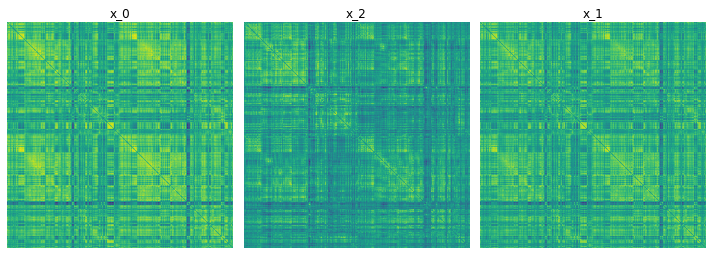

In [30]:
display_cond_generation(fm_model, sample_rest_fmri.to(device), sample_motor_fmri.to(device))